In [ ]:
EXPORT = False

# Forewords

This notebook gathers the analysis of transcription factors motifs within miRNAs promoters.

# Imports and definitions

In [2]:
import itertools as itt
from pathlib import Path
import json

import Bio.SeqIO
import pandas as pd
import numpy as np
import scipy.stats
import sklearn.preprocessing
import statsmodels.stats.multitest

from dotmap import DotMap

from typing import Union, List, Dict

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Image, SVG

# Load

In [3]:
DATA = DotMap()

In [4]:
# motifs table : mapping the cryptic IDs to a gene symbol
path = Path("../../../storage/external_resources/JASPAR2024/table_ids.tsv")
df = pd.read_csv(path, header=0, index_col=None, sep="\t")
DATA['input']['motifs']['table_id'] = df

DATA['input']['motifs']['motif_ac_to_name'] = df.set_index('AC')['ID'].to_dict()

In [5]:
# Load the hits

fp = Path(
    "../../../storage/MAIN_DATA/promoters_mirnas/motif_hits/u1500_d500/processed/{MOTIF_ID}.bed.gz"
)

for motif_id_fp in fp.parent.glob("*.bed.gz"):
    df = pd.read_csv(motif_id_fp, header=0, index_col=None, sep="\t")
    df.columns = ["chrom", "start", "end", "name", "score", "strand", "metadata"]
    # Cast the metadata to a dict
    df["metadata"] = df["metadata"].apply(json.loads)

    DATA["input"]["motifs"]["hits"][motif_id_fp.name.rsplit(".", maxsplit=1)[0]] = df

In [7]:
# Load the promoters information

parent_dir = Path("../../../storage/MAIN_DATA/promoters_mirnas/promoters/u1500_d500/")

# Fasta
path = parent_dir / "promoters.fa"

fa_records = Bio.SeqIO.parse(path, "fasta")
fa_records_dict = {record.id: record for record in fa_records}
DATA['input']['promoters']['fasta'] = fa_records_dict


# Bed
path = parent_dir / "promoters.no_chr.bed"

df = pd.read_csv(path, header=None, sep="\t")
df.columns = ['chrom','start','end','name','score','strand']
df['chrom'] = df['chrom'].astype(str)
df['name'] = df['name'].replace(np.nan,'')

# We can use this bed file to make a mapping of promoter identifiers to miRNA lists.
prom_identifier = df['chrom']+':'+df['start'].astype(str)+'-'+df['end'].astype(str)+'('+df['strand']+')'
df['seqid'] = prom_identifier

DATA['input']['promoters']['bed'] = df
seqid_to_mirnas = {k:v.split(',') for k,v in df.set_index('seqid')['name'].to_dict().items()}

# Here: get a mapping between promoter ID and list of miRNA IDs.
DATA['input']['promoters']['seqid_to_mirna'] = seqid_to_mirnas


# We want the reverse as well: a mapping between miRNA ID and list of promoter IDs.
mirna_to_seqids = {}
for seqid, mirnas in seqid_to_mirnas.items():
    for mirna in mirnas:
        if mirna not in mirna_to_seqids:
            mirna_to_seqids[mirna] = []
        mirna_to_seqids[mirna].append(seqid)
DATA['input']['promoters']['mirna_to_seqid'] = mirna_to_seqids

In [8]:
# miRNA data


# miRNA sets: which are the miRNAs we want to test for enrichment?
# => the concordant up-regulated in cluster 1 and 8
# These were already pre-extracted.
path = "../../../storage/MAIN_DATA/miRNA_dea/E14_ivvivt_concordant_upregulated_miRNAs.tsv"
df = pd.read_csv(path, header=0, index_col=0, sep="\t")
DATA['input']['mirnas']['candidate_mirnas'] = df.index.values

path = "../../../storage/MAIN_DATA/miRNA_dea/E14_ivvivt_DEA-miRNA-merged-logFC_clusters.tsv"
df = pd.read_csv(path, header=0, index_col=0, sep="\t")
DATA['input']['mirnas']['ivv_ivt_clustered'] = df

# Here you can assert that the loaded candidate miRNAs are indeed the ones we want:
# - miRNAs that are in the "concordant-upregulated on average" : cluster 1 and 8
# - from that subset: only keep those that actually show an up-regulation in all three experiments

df = DATA['input']['mirnas']['ivv_ivt_clustered'].copy()
columns_experiments = ['diapaused_ICM','mTor_ICM','paused_E14']
column_cluster = "cluster"

is_in_cluster = df[column_cluster].isin([1,8])
is_concordant_up = df.loc[:,columns_experiments].applymap(lambda v: v>0).sum(axis=1) == 3
candidate_mirnas = df.loc[is_in_cluster & is_concordant_up,:].index.values

assert set(candidate_mirnas) == set(DATA['input']['mirnas']['candidate_mirnas'])

# Processing and normalizing scores

In [9]:
PARAMS = DotMap()

## Explore motif hits score distributions

Not all motifs can reach the same scores, so we should work with a normalized score.

Here we will divide the score from each hit by the maximum score for the TF.

The usual shape of the score distribution is a lognormal distribution, with sometimes a bump
towards high scoring hits.

See for instance MA1556.1 = RXRG, motif AGGTCA.

In [10]:
motifs_with_typical_score_hit_distributions = ['MA1607.1', 'MA0801.1', 'MA1623.1']

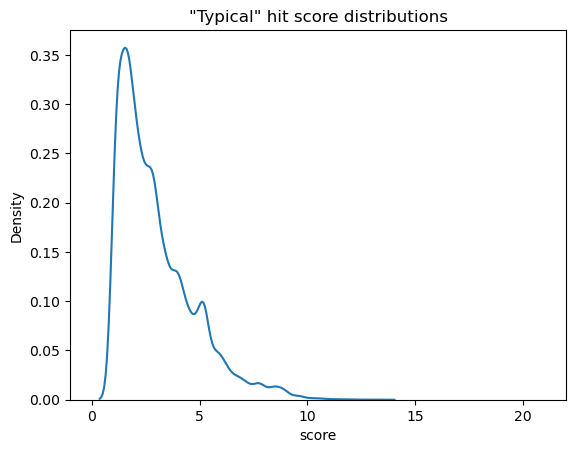

In [11]:
list_motifs_of_interest = motifs_with_typical_score_hit_distributions

tmp_accumulated_hits = pd.concat([
    DATA.input.motifs.hits[motif_id]
    for motif_id in list_motifs_of_interest
])

sns.kdeplot(
    data=tmp_accumulated_hits,
    x='score',
    #hue='motif_id',
    common_norm=False,
    cumulative=False,
    legend=True,
)


plt.xlim(-1,22)
plt.title("\"Typical\" hit score distributions")

plt.show()

MA0075.3


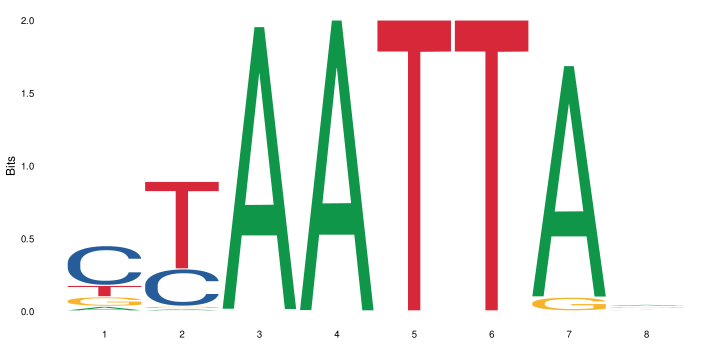

In [12]:
selected_motif_id = "MA0075.3"
print(selected_motif_id)
try:
    display(SVG(f"https://jaspar.genereg.net/static/logos/all/svg/{selected_motif_id}.svg"))
except Exception as e:
    print(e)

In [13]:
# These were accumulated manually

motifs_with_atypical_score_hit_distributions = {
    "AT_rich":[
        "MA0075.3", # TAATTA
        "MA0158.2", # TAATTA
        "MA0666.2", # CAATTA
        "MA0612.2", # TAATTA
        "MA0703.2", # TTAATTA
        "MA0709.1", # CAATTA
        "MA0910.2", # CAATTA
        "MA0900.2", # AATTA
        "MA0902.2", # AATTA
        "MA1473.1", # GCAATAAA
        "MA1499.1", # AATTA
        "MA1495.1", # AATTA
        "MA1502.1", # AATTA
        "MA1507.1", # AATTA
        "MA1577.1", # AATTA
    ],
    "short_high_IC":[
        "MA0006.1", # GCGTG, High information content (0 or 2 bits per nt), short
        "MA0164.1", # High information content (0 or 2 bits per nt), short
        "MA0498.2", # High information content (0 or 2 bits per nt), short
        "MA0633.2", # High information content (0 or 2 bits per nt), short
        "MA0670.1", # High information content (0 or 2 bits per nt), short
        "MA1153.1", # High information content (0 or 2 bits per nt), short
        "MA1684.1", # High information content (0 or 2 bits per nt), short
        "MA1993.1", # High information content (0 or 2 bits per nt), short
    ],
    "long_repeats":[
        "MA0079.5", # Long, G's
        "MA0149.1", # Long, GGAAGGAAGGAA
        "MA0516.3", # Long, G's
        "MA0599.1", # Long, C's
        "MA0740.2", # Long, G's
    ],
    "palindromic_or_paired":[ # Tends to be unimodal or bimodal.
        "MA0004.1", # RC palindrom CACGTG
        "MA0476.1", # SL, TGA_TCA
        "MA0728.1", # Long, pair of AGGTCA
        "MA0729.1", # Long, pair of AGGTCA
        "MA0605.2", # RC palindrome TGACGTCA
        "MA0619.1", # RC Palindrome TTCGAA
        "MA1099.2", # RC palindrome CGCGTG
        "MA1569.1", # dyad symmetry, CC___GG
    ],
    "other":[
        "MA0042.2", # 4/7 are A
        "MA0479.1", # AATCCACA
        "MA0848.1", # A rich
        "MA1155.1", # CACACA
        "MA1563.2", # Nothing particular.
        "MA1965.1", # CCTCCC
    ],
}

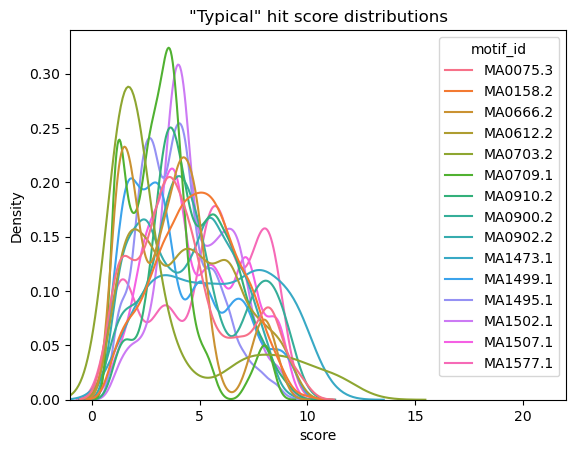

In [14]:
list_motifs_of_interest = motifs_with_atypical_score_hit_distributions['AT_rich']

tmp_accumulated_hits = pd.concat([
    DATA.input.motifs.hits[motif_id].assign(motif_id=motif_id)
    for motif_id in list_motifs_of_interest
])

sns.kdeplot(
    data=tmp_accumulated_hits,
    x='score',
    hue='motif_id',
    common_norm=False,
    cumulative=False,
    legend=True,
)


plt.xlim(-1,22)
plt.title("\"Typical\" hit score distributions")

plt.show()

While some of the "atypical" motifs sort-of make sense w.r.t their hit scores distributions,
(e.g. the dyads and RC pairs), others are more difficult to explain.

For instance: the ATTAA set could be expected to have a symilar, atypical distribution,
but we observe a diversity of distributions.


## Processing the hits

In [15]:
all_hits_list = []
outliers_quantile = 0.90 # clip all hits with larger scores than the NNth percentile to that value.
minmax_scalers = {}

PARAMS['motif_hit_score_normalization_outliers_quantile'] = outliers_quantile


for motif_id, data_hits in DATA.input.motifs.hits.items():
    motif_name = DATA.input.motifs.motif_ac_to_name[motif_id]
    data_hits = data_hits.copy()
    mirnas_sets = data_hits['name'].map(DATA.input.promoters.seqid_to_mirna)
    mirnas_sets_as_string = mirnas_sets.apply(lambda v: ','.join(v))

    data_max_robust = data_hits['score'].quantile(outliers_quantile)
    data_hits['score_clipped'] = data_hits['score'].clip(lower=None, upper=data_max_robust)

    minmax_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
    minmax_scaler.fit(data_hits.loc[:,['score_clipped']])
    score_norm = minmax_scaler.transform(data_hits.loc[:,['score_clipped']]).flatten()

    minmax_scalers[motif_id] = minmax_scaler

    data_hits['motif_id'] = motif_id
    data_hits['max_score'] = data_hits['score'].max()
    data_hits['max_score_robust'] = data_max_robust
    data_hits['score_norm'] = score_norm
    data_hits['motif_name'] = motif_name
    data_hits['mirnas'] = mirnas_sets_as_string

    # This will be used downstream to drop the promoters which are associated with miRNAs that are not measured.
    data_hits['has_measured_mirnas'] = mirnas_sets.apply(lambda v: len(set(v) & set(DATA['input']['mirnas']['ivv_ivt_clustered'].index.values))>0)

    all_hits_list.append(data_hits)


KeyboardInterrupt: 

In [15]:
all_hits = pd.concat(all_hits_list, axis=0, ignore_index=True)
measured_mirnas_proms_hits = all_hits.loc[lambda df: df['has_measured_mirnas'],:].copy()

all_hits['score_rank'] = all_hits['score'].rank(ascending=False)
all_hits['score_norm_rank'] = all_hits['score_norm'].rank(ascending=False)


measured_mirnas_proms_hits['score_rank'] = measured_mirnas_proms_hits['score'].rank(ascending=False)
measured_mirnas_proms_hits['score_norm_rank'] = measured_mirnas_proms_hits['score_norm'].rank(ascending=False)

In [17]:
print(f"Total set of motif hits: {all_hits.shape[0]:,} from {all_hits['motif_id'].unique().shape[0]} motifs in {all_hits['name'].unique().shape[0]:,} promoters.")
print(f"Subset of motif hits in prom. with measured miRNAs: {measured_mirnas_proms_hits.shape[0]:,} from {measured_mirnas_proms_hits['motif_id'].unique().shape[0]} motifs in {measured_mirnas_proms_hits['name'].unique().shape[0]:,} promoters.")

Total set of motif hits: 5,389,949 from 841 motifs in 641 promoters.
Subset of motif hits in prom. with measured miRNAs: 880,714 from 840 motifs in 105 promoters.


In [18]:
all_hits.head(3)

,chrom,start,end,name,score,strand,metadata,score_clipped,motif_id,max_score,max_score_robust,score_norm,motif_name,mirnas,has_measured_mirnas,score_rank,score_norm_rank
0,chr1,20680691,20680702,1:20680448-20682449(+),1.3,+,"{'sequence': 'CTATCATTAGAA', 'Pval': 0.0041, '...",1.3,MA0070.1,12.8,4.7,0.081081,PBX1,"mmu-miR-133b-3p,mmu-miR-133b-5p",False,4578638.5,4505753.5
1,chr1,20680840,20680851,1:20680448-20682449(+),7.6,+,"{'sequence': 'ACAACATTCATA', 'Pval': 6.1e-05, ...",4.7,MA0070.1,12.8,4.7,1.000000,PBX1,"mmu-miR-133b-3p,mmu-miR-133b-5p",False,118778.5,219039.0
2,chr1,20680847,20680858,1:20680448-20682449(+),2.3,+,"{'sequence': 'TCATACATGATA', 'Pval': 0.0023, '...",2.3,MA0070.1,12.8,4.7,0.351351,PBX1,"mmu-miR-133b-3p,mmu-miR-133b-5p",False,2802433.5,2595961.0


/tmp/ipykernel_1537780/2623700585.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(


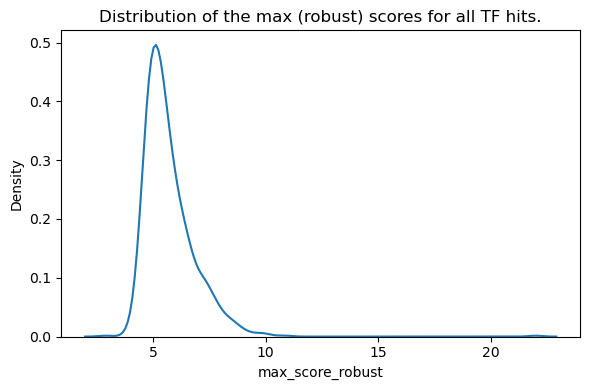

In [19]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)

sns.kdeplot(
    data=all_hits.drop_duplicates(subset=['motif_id']),
    x='max_score_robust',
    palette={'max_score_robust':'blue'},
    ax=ax1,
)

ax1.set_title("Distribution of the max (robust) scores for all TF hits.")

plt.tight_layout()

plt.show()

## Define a score threshold

In [20]:
QUANTILES_VALUES = [0.25, 0.50, 0.75, 0.9, 0.95, 0.99]
QUANTILES_VALUES_STR = ["0.25", "0.50", "0.75", "0.90", "0.95", "0.99"]

### Across TFs 

In [21]:
def plot_density(scores: pd.Series, subsample: Union[int, float]=0.1, title: str = "") -> Dict[str, float]:
    if not subsample > 0:
        raise ValueError("Expected either a fraction or a round number.")

    if subsample > scores.shape[0]:
        subsample = scores.shape[0]

    if subsample <= 1:
        subsample = int(scores.shape[0]*subsample)

    scores_subsample = scores.sample(subsample)

    fig = plt.figure(figsize=(6, 4))
    ax1 = fig.add_subplot(1,1,1)

    sns.kdeplot(
        scores_subsample,
        ax=ax1
    )

    quantiles = scores_subsample.quantile(QUANTILES_VALUES)

    for quantile, value in quantiles.items():
        ax1.axvline(value, color='red', linestyle='--',)
        ax1.text(value, 0.1, f"{quantile:.2f}", rotation=90, verticalalignment='bottom', color='red')
        # Add the weight value at the bottom of the line (on the x axis)
        ax1.text(value, -0.0, f"{value:.2f}", rotation=90, verticalalignment='top', color='red')

    ax1.set_title(title)

    plt.tight_layout()
    plt.show()

    return dict(zip(QUANTILES_VALUES_STR, np.round(quantiles, 2)))


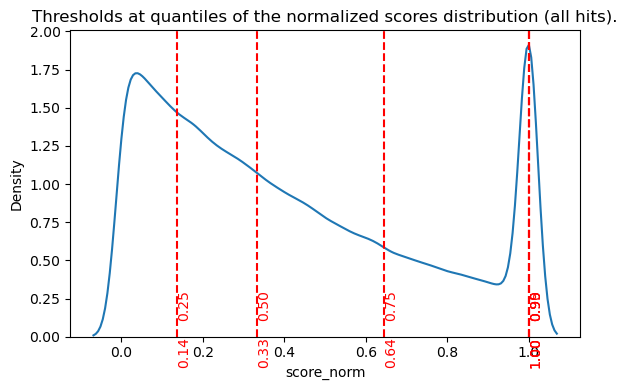

{'0.25': 0.14, '0.50': 0.33, '0.75': 0.64, '0.90': 1.0, '0.95': 1.0, '0.99': 1.0}


In [22]:
# NORMALIZED SCORE - ALL HITS
tmp_quantiles = plot_density(
    all_hits['score_norm'],
    subsample=0.1,
    title="Thresholds at quantiles of the normalized scores distribution (all hits).",
)

print(tmp_quantiles)


allhits_norm_score_thresholds_quantiles = tmp_quantiles

NOTE: because of the clipping of outliers, the quantiles are a bit messed up.

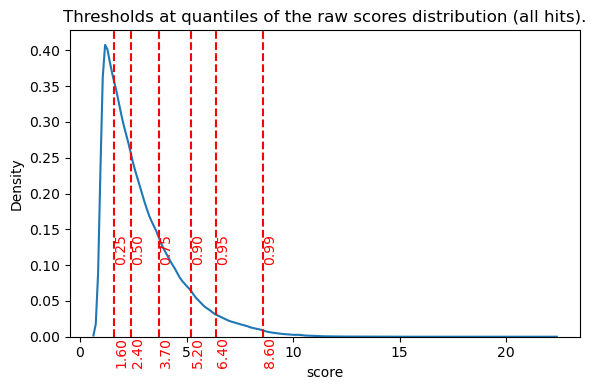

{'0.25': 1.6, '0.50': 2.4, '0.75': 3.7, '0.90': 5.2, '0.95': 6.4, '0.99': 8.6}


In [23]:
# RAW SCORE - ALL HITS
tmp_quantiles = plot_density(
    all_hits['score'],
    subsample=0.1,
    title="Thresholds at quantiles of the raw scores distribution (all hits).",
)

print(tmp_quantiles)

allhits_score_threshold_quantiles = tmp_quantiles

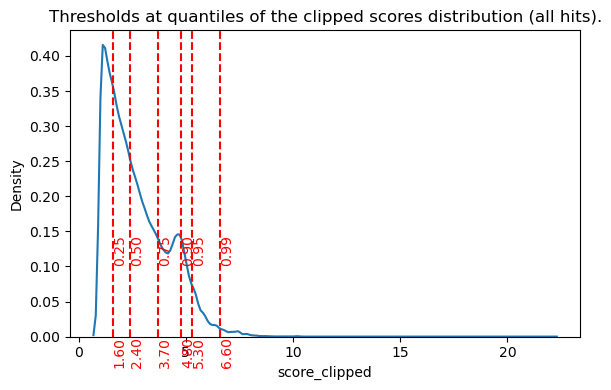

{'0.25': 1.6, '0.50': 2.4, '0.75': 3.7, '0.90': 4.8, '0.95': 5.3, '0.99': 6.6}


In [24]:
# CLIPPED SCORE - ALL HITS
tmp_quantiles = plot_density(
    all_hits['score_clipped'],
    subsample=0.1,
    title="Thresholds at quantiles of the clipped scores distribution (all hits).",
)

print(tmp_quantiles)

allhits_score_clipped_threshold_quantiles = tmp_quantiles

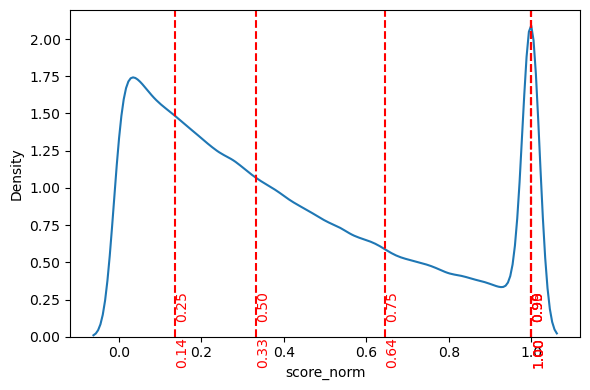

{'0.25': 0.14, '0.50': 0.33, '0.75': 0.64, '0.90': 1.0, '0.95': 1.0, '0.99': 1.0}


In [25]:
# NORMALIZED SCORE - measured-promoters HITS
tmp_quantiles = plot_density(
    measured_mirnas_proms_hits['score_norm'],
    subsample=1.0,
)

print(tmp_quantiles)

measuredpromhits_norm_score_thresholds_quantiles = tmp_quantiles

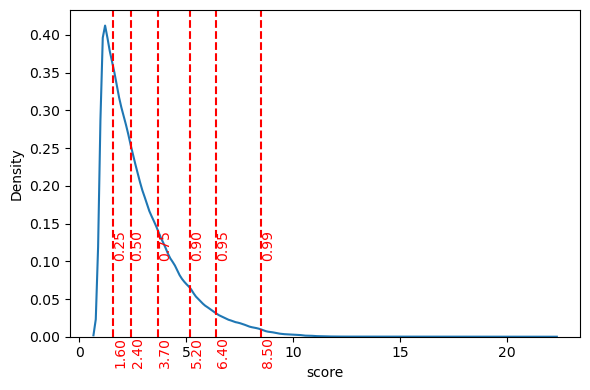

{'0.25': 1.6, '0.50': 2.4, '0.75': 3.7, '0.90': 5.2, '0.95': 6.4, '0.99': 8.5}


In [27]:
# RAW SCORE - measured-promoters HITS
tmp_quantiles = plot_density(measured_mirnas_proms_hits['score'], subsample=1.0)

print(tmp_quantiles)

# verify those values on the plot.
measuredpromhits_score_threshold_quantiles = tmp_quantiles

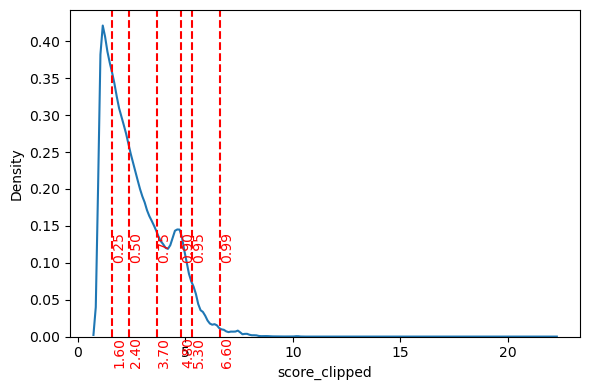

{'0.25': 1.6, '0.50': 2.4, '0.75': 3.7, '0.90': 4.8, '0.95': 5.3, '0.99': 6.6}


In [28]:
# CLIPPED SCORE - measured-promoters HITS
tmp_quantiles = plot_density(measured_mirnas_proms_hits['score_clipped'], subsample=1.0)

print(tmp_quantiles)

# verify those values on the plot.
measuredpromhits_score_clipped_threshold_quantiles = tmp_quantiles

### Per TFs

In [29]:
allhits_per_tf_quantiles = {}

for score_name in ['score', 'score_clipped']:
    allhits_per_tf_quantiles[score_name] = {}

    for motif_id, data_hits in all_hits.groupby('motif_id'):

        quantiles = data_hits[score_name].quantile(QUANTILES_VALUES)
        allhits_per_tf_quantiles[score_name][motif_id] = dict(zip(QUANTILES_VALUES_STR, np.round(quantiles, 2)))

measuredpromhits_per_tf_quantiles = {}

for score_name in ['score', 'score_clipped']:
    measuredpromhits_per_tf_quantiles[score_name] = {}

    for motif_id, data_hits in measured_mirnas_proms_hits.groupby('motif_id'):

        quantiles = data_hits[score_name].quantile(QUANTILES_VALUES)
        measuredpromhits_per_tf_quantiles[score_name][motif_id] = dict(zip(QUANTILES_VALUES_STR, np.round(quantiles, 2)))

### Chose and apply the thresholding approach

In [30]:

different_score_thresholds_quantiles = {
    'all_hits': {
        'across_tf':{
            'score': allhits_score_threshold_quantiles,
            'score_norm': allhits_norm_score_thresholds_quantiles,
            'score_clipped': allhits_score_clipped_threshold_quantiles,
        },
        'per_tf': {
            'score_clipped': allhits_per_tf_quantiles['score_clipped'],
            'score': allhits_per_tf_quantiles['score'],
        },
    },
    'measured_mirnas_proms_hits': {
        'across_tf':{
            'score': measuredpromhits_score_threshold_quantiles,
            'score_norm': measuredpromhits_norm_score_thresholds_quantiles,
            'score_clipped': measuredpromhits_score_clipped_threshold_quantiles,
        },
        'per_tf':{
            'score_clipped': measuredpromhits_per_tf_quantiles['score_clipped'],
            'score': measuredpromhits_per_tf_quantiles['score'],
        },
    }
}


In [31]:
working_params = {
    1: {
        "chosen_set_hits": "measured_mirnas_proms_hits",
        "chosen_threshold_mode": "across_tf",
        "chosen_score": "score",
        "chosen_quantile" : "0.75"
    },
    2: {
        "chosen_set_hits": "measured_mirnas_proms_hits",
        "chosen_threshold_mode": "per_tf",
        "chosen_score": "score_clipped",
        "chosen_quantile": "0.50"
    },
    3: {
        "chosen_set_hits": "measured_mirnas_proms_hits",
        "chosen_threshold_mode": "per_tf",
        "chosen_score": "score",
        "chosen_quantile": "0.50"
    },
}

# FINAL CHOSEN: the number 3: simpler to explain (no clipping ; per TF, hits with score above the median score)

In [32]:
#chosen_set_hits = "all_hits"
chosen_set_hits = "measured_mirnas_proms_hits"
chosen_threshold_mode = "per_tf"
chosen_score = 'score'
chosen_quantile = "0.50"

hits_source = {
    'all_hits':all_hits,
    'measured_mirnas_proms_hits':measured_mirnas_proms_hits,
}


if chosen_threshold_mode == 'per_tf':
    #raise NotImplementedError

    score_threshold = {
        motif_id: motif_id_quantiles_thresholds[chosen_quantile]
        for motif_id, motif_id_quantiles_thresholds in different_score_thresholds_quantiles[chosen_set_hits][chosen_threshold_mode][chosen_score].items()
    }

    filtered_hits = hits_source[chosen_set_hits].loc[
        lambda df: (df[chosen_score] >= df['motif_id'].apply(lambda v: score_threshold[v])),
    :]
    print(f"Thresholding {chosen_threshold_mode} on score '{chosen_score}' (quantile={chosen_quantile})")

else:
    # This is either a single numeric value, or a dict mapping motif_ids to a single numeric value.
    # Here : this is a numeric value.
    score_threshold = different_score_thresholds_quantiles[chosen_set_hits][chosen_threshold_mode][chosen_score][chosen_quantile]

    filtered_hits = hits_source[chosen_set_hits].loc[lambda df: df[chosen_score] >= score_threshold, :]

    print(f"Thresholding {chosen_threshold_mode} on score '{chosen_score}' (quantile={chosen_quantile}): {score_threshold:.2f}")

print(f"Number of transcription factors retained after threshold: {filtered_hits['motif_id'].unique().shape[0]:,} / {all_hits['motif_id'].unique().shape[0]:,}")
print(f"Number of motif hits retained after threshold: {filtered_hits.shape[0]:,} / {all_hits.shape[0]:,}")

Thresholding per_tf on score 'score' (quantile=0.50)
Number of transcription factors retained after threshold: 840 / 841
Number of motif hits retained after threshold: 453,101 / 5,389,949


In [33]:
filtered_hits.sort_values(
    by='score',
    ascending=False,
).head(3)

,chrom,start,end,name,score,strand,metadata,score_clipped,motif_id,max_score,max_score_robust,score_norm,motif_name,mirnas,has_measured_mirnas,score_rank,score_norm_rank
4474567,chr10,94035602,94035619,10:94035248-94037249(-),22.0,-,"{'sequence': 'GGAAGGAAGGAAGGAAGG', 'Pval': 1.6...",22.0,MA0149.1,22.0,22.0,1.0,EWSR1-FLI1,"mmu-miR-331-3p,mmu-miR-331-5p",True,7.0,91903.0
4474574,chr10,94035630,94035647,10:94035248-94037249(-),22.0,-,"{'sequence': 'GGAAGGAAGGAAGGAAGG', 'Pval': 1.6...",22.0,MA0149.1,22.0,22.0,1.0,EWSR1-FLI1,"mmu-miR-331-3p,mmu-miR-331-5p",True,7.0,91903.0
4474568,chr10,94035606,94035623,10:94035248-94037249(-),22.0,-,"{'sequence': 'GGAAGGAAGGAAGGAAGG', 'Pval': 1.6...",22.0,MA0149.1,22.0,22.0,1.0,EWSR1-FLI1,"mmu-miR-331-3p,mmu-miR-331-5p",True,7.0,91903.0


# Split filtered hits per miRNA set and test

In [34]:
print(DATA.input.mirnas.candidate_mirnas)

['mmu-miR-1839-5p' 'mmu-miR-205-5p' 'mmu-miR-26b-5p' 'mmu-miR-23a-3p'
 'mmu-miR-27b-3p' 'mmu-miR-676-3p' 'mmu-miR-200b-5p' 'mmu-miR-200b-3p'
 'mmu-miR-200c-3p' 'mmu-miR-30b-5p' 'mmu-miR-200a-3p' 'mmu-miR-141-3p'
 'mmu-miR-148a-3p' 'mmu-miR-30d-5p' 'mmu-miR-429-3p' 'mmu-let-7d-5p'
 'mmu-miR-98-5p' 'mmu-miR-503-3p' 'mmu-miR-434-3p' 'mmu-miR-532-3p'
 'mmu-miR-322-5p' 'mmu-let-7g-5p' 'mmu-miR-224-5p' 'mmu-miR-574-5p']


In [35]:
candidate_mirnas_promoters = list(
    itt.chain(
        *[
            DATA.input.promoters.mirna_to_seqid[mirna]
            for mirna in DATA.input.mirnas.candidate_mirnas
            if mirna in DATA.input.promoters.mirna_to_seqid
        ]
    )
)

candidate_mirnas_without_promoters = [
    mirna for mirna in DATA.input.mirnas.candidate_mirnas
    if mirna not in DATA.input.promoters.mirna_to_seqid
]

other_promoters = list(set(DATA.input.promoters.bed['seqid']) - set(candidate_mirnas_promoters))
print(len(other_promoters))

# "other_promoters" need to be subset so as to keep only the promoters with measured miRNAs,
# if the set of hits is "measured_mirnas_proms_hits"
if chosen_set_hits == "measured_mirnas_proms_hits":
    other_promoters = list(set(other_promoters) & set(measured_mirnas_proms_hits['name'].unique()))
    print(len(other_promoters))

627
91


In [36]:
print(len(candidate_mirnas_promoters))
print(len(other_promoters))

18
91


In [37]:
is_hit_int_candidate_prom = filtered_hits['name'].isin(candidate_mirnas_promoters)
filtered_hits_CANDIDATES = filtered_hits.loc[is_hit_int_candidate_prom,:]
filtered_hits_OTHERS = filtered_hits.loc[~is_hit_int_candidate_prom,:]

grouped_filtered_hits_CANDIDATES = filtered_hits_CANDIDATES.groupby('motif_id')
grouped_filtered_hits_OTHERS = filtered_hits_OTHERS.groupby('motif_id')

## Explore

In [38]:
DATA.input.motifs.table_id.loc[lambda df: df['ID'].isin(['TFEB','TFE3','MAX'])]

,AC,ID
147,MA0692.1,TFEB
258,MA0058.3,MAX
806,MA0831.3,TFE3


## Explore: number of motif hits (accept more than one hit per promoter)

In [39]:
table_counts_motif_hits = []

for idx_row, motif_id_ac in DATA.input.motifs.table_id.iterrows():
    if motif_id_ac['AC'] not in grouped_filtered_hits_CANDIDATES.groups:
        count_candidates = 0
    else:
        count_candidates = grouped_filtered_hits_CANDIDATES.get_group(motif_id_ac['AC']).shape[0]
    if motif_id_ac['AC'] not in grouped_filtered_hits_OTHERS.groups:
        count_others = 0
    else:
        count_others = grouped_filtered_hits_OTHERS.get_group(motif_id_ac['AC']).shape[0]

    table_counts_motif_hits.append(
        pd.Series(
            {
                **motif_id_ac.to_dict(),
                'count_candidates': count_candidates,
                'count_others': count_others,
            }
        )
    )

table_counts_motif_hits = pd.DataFrame(table_counts_motif_hits).sort_values(by=['count_candidates'], ascending=False).reset_index(drop=True)
table_counts_motif_hits['ratio'] = (table_counts_motif_hits['count_candidates']+1) / (table_counts_motif_hits['count_others']+1)

In [40]:
table_counts_motif_hits.loc[lambda df: df['ID'].isin(['TFEB', 'TFE3', 'MAX'])]

,AC,ID,count_candidates,count_others,ratio
339,MA0692.1,TFEB,74,414,0.180723
421,MA0058.3,MAX,54,313,0.175159
707,MA0831.3,TFE3,10,51,0.211538


## Test: number of promoters (0 or 1 hit per promoter)

In [41]:
# For each transcription factor, gather the number of promoters in each set.
# Do not forget to count the promoters that are absent because of lack of motifs.

table_counts_promoters_hits = []

for idx_row, motif_id_ac in DATA.input.motifs.table_id.iterrows():
    if motif_id_ac['AC'] not in grouped_filtered_hits_CANDIDATES.groups:
        count_candidates_w_hit = 0
        count_candidates_wo_hit = len(candidate_mirnas_promoters)
    else:
        mirnas_promoters_w_hit = grouped_filtered_hits_CANDIDATES.get_group(motif_id_ac['AC'])['name'].unique()

        count_candidates_w_hit = len(mirnas_promoters_w_hit)
        count_candidates_wo_hit = len(set(list(candidate_mirnas_promoters)) - set(list(mirnas_promoters_w_hit)))

    if motif_id_ac['AC'] not in grouped_filtered_hits_OTHERS.groups:
        count_others_w_hit = 0
        count_others_wo_hit = len(candidate_mirnas_promoters)
    else:
        mirnas_promoters_w_hit = grouped_filtered_hits_OTHERS.get_group(motif_id_ac['AC'])['name'].unique()

        count_others_w_hit = len(mirnas_promoters_w_hit)
        count_others_wo_hit = len(set(other_promoters) - set(mirnas_promoters_w_hit))

    table_counts_promoters_hits.append(
        pd.Series(
            {
                **motif_id_ac.to_dict(),
                'count_candidates_w_hit': count_candidates_w_hit,
                'count_candidates_wo_hit': count_candidates_wo_hit,
                'count_others_w_hit': count_others_w_hit,
                'count_others_wo_hit': count_others_wo_hit,
            }
        )
    )

table_counts_promoters_hits = pd.DataFrame(table_counts_promoters_hits)

In [42]:
# Apply fisher test to each transcription factor.

table_counts_promoters_hits['odds_ratio'] = np.nan
table_counts_promoters_hits['pval'] = np.nan

for i, row in table_counts_promoters_hits.iterrows():

    table_cts = np.array([
        [row['count_candidates_w_hit'], row['count_candidates_wo_hit']],
        [row['count_others_w_hit'], row['count_others_wo_hit']],
    ])
    odds_ratio, pval = scipy.stats.fisher_exact(
        table_cts,
        alternative='greater',
    )
    # Manually calculate the odds ratio with added pseudo counts.
    pseudo_count = 1
    odds_ratio_alt = (
        ( (table_cts[0,0]+pseudo_count) / (table_cts[0,1]+pseudo_count) ) / \
        ( (table_cts[1,0]+pseudo_count) / (table_cts[1,1]+pseudo_count) )
    )
    table_counts_promoters_hits.loc[i, 'odds_ratio'] = odds_ratio_alt
    table_counts_promoters_hits.loc[i, 'pval'] = pval

# Not sure if it makes sense to correct for multiple testing here?
# We have scanned with the full set of transcription factors, while we should have
# pre-selected (e.g. for development-related transcription factors).
# But on the other hand : without correction we would consider significant
# many spurious tests.

reject_bool, pvals_corrected, _, _ = statsmodels.stats.multitest.multipletests(
    table_counts_promoters_hits['pval'].values,
    alpha=0.01,
    method='bonferroni',
)

table_counts_promoters_hits['pval_corrected'] = pvals_corrected


In [43]:
table_counts_promoters_hits.loc[lambda df: df['ID'].isin(['TFEB', 'TFE3', 'MAX'])]

,AC,ID,count_candidates_w_hit,count_candidates_wo_hit,count_others_w_hit,count_others_wo_hit,odds_ratio,pval,pval_corrected
147,MA0692.1,TFEB,14,0,88,3,0.674157,0.648058,1.0
258,MA0058.3,MAX,13,1,85,6,0.569767,0.765612,1.0
806,MA0831.3,TFE3,9,5,34,57,2.761905,0.054144,1.0


In [44]:
# THIS IS A MANDATORY HIT TO HAVE : we display it as an example for the experimental validation.
filtered_hits_CANDIDATES.loc[
    lambda df: (df['mirnas'].str.contains('200b')) & (df['motif_name'] == 'TFE3'),:]

,chrom,start,end,name,score,strand,metadata,score_clipped,motif_id,max_score,max_score_robust,score_norm,motif_name,mirnas,has_measured_mirnas,score_rank,score_norm_rank
2896986,chr4,156059483,156059492,4:156059316-156061317(-),5.2,-,"{'sequence': 'TTCATGTGAC', 'Pval': 0.0001, 'ln...",5.2,MA0831.3,13.7,7.5,0.646154,TFE3,"mmu-miR-200a-3p,mmu-miR-200a-5p,mmu-miR-200b-3...",True,90994.5,219480.5


In [43]:
# HERE : SHOWING THE RESULTS FOR THE 3 CANDIDATE TFs

table_counts_promoters_hits.loc[
    lambda df: df['count_candidates_w_hit']>0,
    :
].reset_index(
    drop=True
).sort_values(
    by='odds_ratio', ascending=False
).loc[lambda df: df['ID'].isin(['TFEB', 'TFE3', 'MAX'])]

,AC,ID,count_candidates_w_hit,count_candidates_wo_hit,count_others_w_hit,count_others_wo_hit,odds_ratio,pval,pval_corrected
785,MA0831.3,TFE3,9,5,34,57,2.761905,0.054144,1.0
144,MA0692.1,TFEB,14,0,88,3,0.674157,0.648058,1.0
246,MA0058.3,MAX,13,1,85,6,0.569767,0.765612,1.0


In [44]:
table_counts_promoters_hits.loc[
    lambda df: (
        (df['count_candidates_w_hit']>0) & \
        (df['odds_ratio']>1)
    ),:
    ].sort_values(by='odds_ratio', ascending=False
    ).loc[lambda df: df['pval']<0.1].reset_index(drop=True)

,AC,ID,count_candidates_w_hit,count_candidates_wo_hit,count_others_w_hit,count_others_wo_hit,odds_ratio,pval,pval_corrected
0,MA1546.1,PAX3,14,0,68,23,5.217391,0.023964,1.0
1,MA0798.3,RFX3,3,11,5,86,4.833333,0.071225,1.0
2,MA1940.1,ETV2::DRGX,14,0,71,20,4.375000,0.041413,1.0
3,MA1550.1,PPARD,8,6,22,69,3.913043,0.015978,1.0
4,MA0507.2,POU2F2,7,7,18,73,3.894737,0.020782,1.0
5,MA1155.1,ZSCAN4,5,9,12,79,3.692308,0.048705,1.0
6,MA1463.1,ARGFX,14,0,74,17,3.600000,0.070104,1.0
7,MA0780.1,PAX3,12,2,51,40,3.416667,0.030241,1.0
8,MA1537.1,NR2F1,9,5,30,61,3.333333,0.026569,1.0
9,MA0074.1,RXRA::VDR,14,0,76,15,3.116883,0.098515,1.0


In [45]:
# At least one hit in candidate promoters, odds ratio > 1
tmp1 = table_counts_promoters_hits.loc[
    lambda df: (
        (df['count_candidates_w_hit']>0) & \
        (df['odds_ratio']>1)
    ),:
    ].sort_values(by='pval', ascending=True,
    ).reset_index(drop=True)

# At least one hit in candidate promoters, odds ratio > 2
tmp2 = table_counts_promoters_hits.loc[
    lambda df: (
        (df['count_candidates_w_hit']>0) & \
        (df['odds_ratio']>2)
    ),:
    ].sort_values(by='pval', ascending=True,
    ).reset_index(drop=True)

# At least one hit in candidate promoters, odds ratio > 2, pass significance threshold
tmp3 = table_counts_promoters_hits.loc[
    lambda df: (
        (df['count_candidates_w_hit']>0) & \
        (df['odds_ratio']>2) & \
        (df['pval']<0.1)
    ),:
    ].sort_values(by='pval', ascending=True,
    ).reset_index(drop=True)



In [52]:
table_counts_promoters_hits.sort_values(by='pval', ascending=True).head(15)

,AC,ID,count_candidates_w_hit,count_candidates_wo_hit,count_others_w_hit,count_others_wo_hit,odds_ratio,pval,pval_corrected
446,MA1550.1,PPARD,8,6,22,69,3.913043,0.015978,1.0
763,MA0507.2,POU2F2,7,7,18,73,3.894737,0.020782,1.0
443,MA1546.1,PAX3,14,0,68,23,5.217391,0.023964,1.0
436,MA1537.1,NR2F1,9,5,30,61,3.333333,0.026569,1.0
217,MA0780.1,PAX3,12,2,51,40,3.416667,0.030241,1.0
412,MA1506.1,HOXD10,9,5,32,59,3.030303,0.038499,1.0
678,MA1940.1,ETV2::DRGX,14,0,71,20,4.375000,0.041413,1.0
350,MA1155.1,ZSCAN4,5,9,12,79,3.692308,0.048705,1.0
528,MA0702.2,LMX1A,12,2,54,37,2.993939,0.049295,1.0
806,MA0831.3,TFE3,9,5,34,57,2.761905,0.054144,1.0


In [53]:
# Full set of results, sorted by raw P-value
tmp_n = table_counts_promoters_hits.sort_values(
    by='pval', ascending=True
).drop(
    columns=['pval_corrected']
)

In [50]:
EXPORT = False


if EXPORT:
    tmp_n.to_csv("./motifs_hits_count_measured_promoters.ALL.tsv", header=True, index=False, sep="\t")
    tmp1.to_csv("./motifs_hits_count_measured_promoters.subset_OR1.tsv", sep="\t", header=True, index=False)
    tmp3.to_csv("./motifs_hits_count_measured_promoters.subset_OR2.tsv", sep="\t", header=True, index=False)
    tmp3.to_csv("./motifs_hits_count_measured_promoters.subset_OR2_pval0_1.tsv", sep="\t", header=True, index=False)

# Plot

Here we want to represent visually the top TF motifs showing enrichment in candidate promoters.

In [62]:
tmp_n.loc[lambda df: df['pval']<0.1]

,AC,ID,count_candidates_w_hit,count_candidates_wo_hit,count_others_w_hit,count_others_wo_hit,odds_ratio,pval
446,MA1550.1,PPARD,8,6,22,69,3.913043,0.015978
763,MA0507.2,POU2F2,7,7,18,73,3.894737,0.020782
443,MA1546.1,PAX3,14,0,68,23,5.217391,0.023964
436,MA1537.1,NR2F1,9,5,30,61,3.333333,0.026569
217,MA0780.1,PAX3,12,2,51,40,3.416667,0.030241
412,MA1506.1,HOXD10,9,5,32,59,3.030303,0.038499
678,MA1940.1,ETV2::DRGX,14,0,71,20,4.375000,0.041413
350,MA1155.1,ZSCAN4,5,9,12,79,3.692308,0.048705
528,MA0702.2,LMX1A,12,2,54,37,2.993939,0.049295
806,MA0831.3,TFE3,9,5,34,57,2.761905,0.054144


In [99]:
tmp_plot=tmp_n.loc[lambda df: df['pval']<0.1,:].assign(min_log10_pval=lambda df: -df['pval'].map(np.log10))

In [100]:
tmp_plot

,AC,ID,count_candidates_w_hit,count_candidates_wo_hit,count_others_w_hit,count_others_wo_hit,odds_ratio,pval,min_log10_pval
446,MA1550.1,PPARD,8,6,22,69,3.913043,0.015978,1.796486
763,MA0507.2,POU2F2,7,7,18,73,3.894737,0.020782,1.682311
443,MA1546.1,PAX3,14,0,68,23,5.217391,0.023964,1.620439
436,MA1537.1,NR2F1,9,5,30,61,3.333333,0.026569,1.575619
217,MA0780.1,PAX3,12,2,51,40,3.416667,0.030241,1.519403
412,MA1506.1,HOXD10,9,5,32,59,3.030303,0.038499,1.414549
678,MA1940.1,ETV2::DRGX,14,0,71,20,4.375000,0.041413,1.382868
350,MA1155.1,ZSCAN4,5,9,12,79,3.692308,0.048705,1.312424
528,MA0702.2,LMX1A,12,2,54,37,2.993939,0.049295,1.307195
806,MA0831.3,TFE3,9,5,34,57,2.761905,0.054144,1.266452


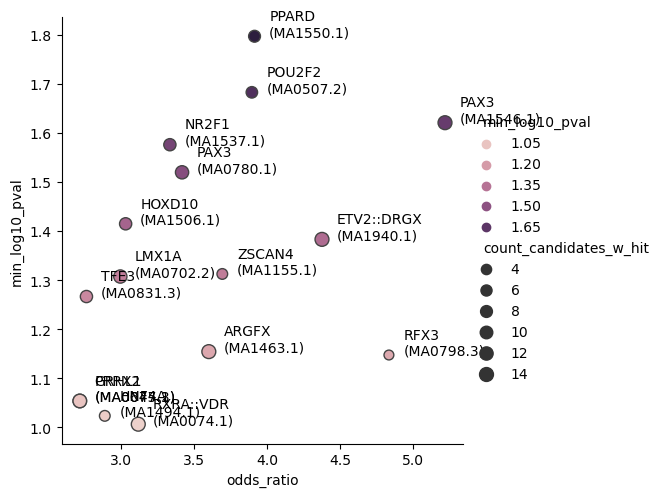

In [98]:
# fig = plt.figure(figsize=(10,8))


g = sns.relplot(
    data=tmp_plot,
    y="min_log10_pval",
    x="odds_ratio",
    hue="min_log10_pval",
    size="count_candidates_w_hit",
    sizes=(50, 100),
    linewidth=1,
    edgecolor="#444444",
)


# g.axes[0].grid(True)
g.ax.grid(False)

for i, row in tmp_plot.iterrows():
    g.ax.annotate(
        xy=(row["odds_ratio"], row["min_log10_pval"]),
        xytext=(row["odds_ratio"] + 0.1, row["min_log10_pval"]),
        text=f"{row['ID']}\n({row['AC']})",
    )

# plt.tight_layout()
if EXPORT:
    plt.savefig("plot_significant_enriched_hits.svg")

plt.show()